# Python script to plot data from 01EMMA_CYL

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
from netCDF4 import Dataset
from __future__ import print_function
import ipywidgets as widget
from IPython.display import display
from matplotlib import animation, rc
from IPython.display import HTML
from lxml import etree
import requests

In [2]:
%matplotlib notebook

## plotting function

In [3]:
def animate(i):
    print('Loading frame ' + str(i + 1) + '/' + str(frames))
    if variable_glob == 'norm':
        norm = np.sqrt(rootgrp[i].variables['u'][0, 0, :, :]**2 +
                       rootgrp[i].variables['v'][0, 0, :, :]**2)
        mycontour = matplotlib.pyplot.contourf(norm, 50, cmap=contourcolor)
    else:
        varplot = rootgrp[i].variables[variable_glob][0, 0, :, :]
        mycontour = matplotlib.pyplot.contourf(varplot, 50, cmap=contourcolor)
    if vector_glob:
        matplotlib.pyplot.quiver(x, y, rootgrp[i].variables['u'][0, 0, :, :],
                   rootgrp[i].variables['v'][0, 0, :, :])
    return mycontour

## Interactive function

In [4]:
def g(folder, variable, vector, launch):
    url_base = 'http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/' + folder + '/'
    catalog_file = requests.get(url_base + 'catalog.xml')
    tree = etree.fromstring(catalog_file.content)

    items = 0
    for children in tree[2]:
        if '.nc' in children.get("name"):
            items += 1

    if launch:
        file_name = []
        
        # GLobal variables
        global rootgrp
        global variable_glob
        global vector_glob
        global x
        global y
        global contourcolor
        global frames
        global ani
        
        vector_glob = vector
        variable_glob = variable
        rootgrp = []
        i = 0
        j = 1
        
        while j <= items:
            print('Reading file ' + str(j) + '/' + str(items))
            if len(str(int(j))) == 1:
                file_name.append(folder +'_etat00' + str(int(j)) + '.nc')
            elif len(str(int(j))) == 2:
                file_name.append(folder +'_etat0' + str(int(j)) + '.nc')
            else:
                file_name.append(folder + '_etat' + str(int(j)) + '.nc')
            print(url_base + file_name[i])
            rootgrp.append(Dataset(url_base + file_name[i]))
            j += 5
            i += 1
        print('All files loaded')
        
        frames = i
        matplotlib.pyplot.clf()   
        fig_xsize = 15
        fig_ysize = 10
        font_size = 25
        markersize = 10
        fig = matplotlib.pyplot.figure(num=0, figsize=(fig_xsize, fig_ysize), dpi=60,
                                       facecolor='w', edgecolor='w')
        matplotlib.pyplot.rcParams.update({'font.size': font_size})
        matplotlib.pyplot.rcParams['lines.markersize'] = 10
        xaxis_name = 'i'
        yaxis_name = 'j'
        xlin = np.linspace(0, 49, 50)
        x, y = np.meshgrid(xlin, xlin)
        contourcolor = matplotlib.pyplot.cm.coolwarm
        mycontour = matplotlib.pyplot.contourf(x, 50, cmap=contourcolor)
        ani = animation.FuncAnimation(fig, animate, frames=i, interval=1, blit=False)
        cbar = matplotlib.pyplot.colorbar(mycontour)
        cbar.ax.set_ylabel('Velocity (m/s)')
        matplotlib.pyplot.gca().set_aspect('equal')
        matplotlib.pyplot.xlabel(xaxis_name)
        matplotlib.pyplot.ylabel(yaxis_name)

## Load files:

Reading file 1/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat001.nc
Reading file 6/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat006.nc
Reading file 11/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat011.nc
Reading file 16/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat016.nc
Reading file 21/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat021.nc
Reading file 26/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat026.nc
Reading file 31/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat031.nc
Reading file 36/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat036.nc
Reading file 41/100
http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/cc_etat041.nc
Reading file 46/100
http://servdap.legi.grenoble-inp.fr:80/opendap

<IPython.core.display.Javascript object>


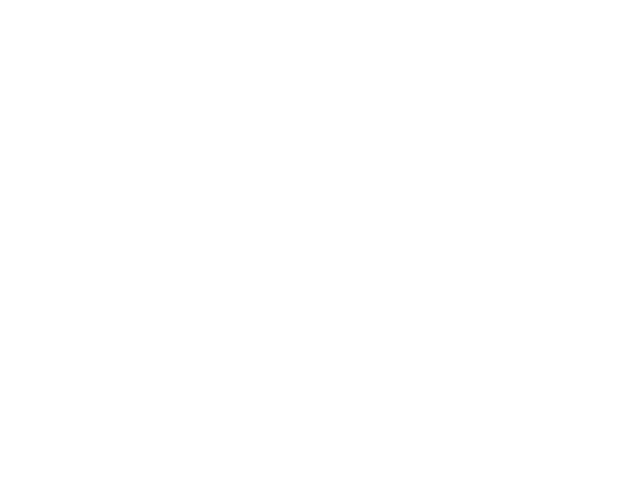

<IPython.core.display.Javascript object>


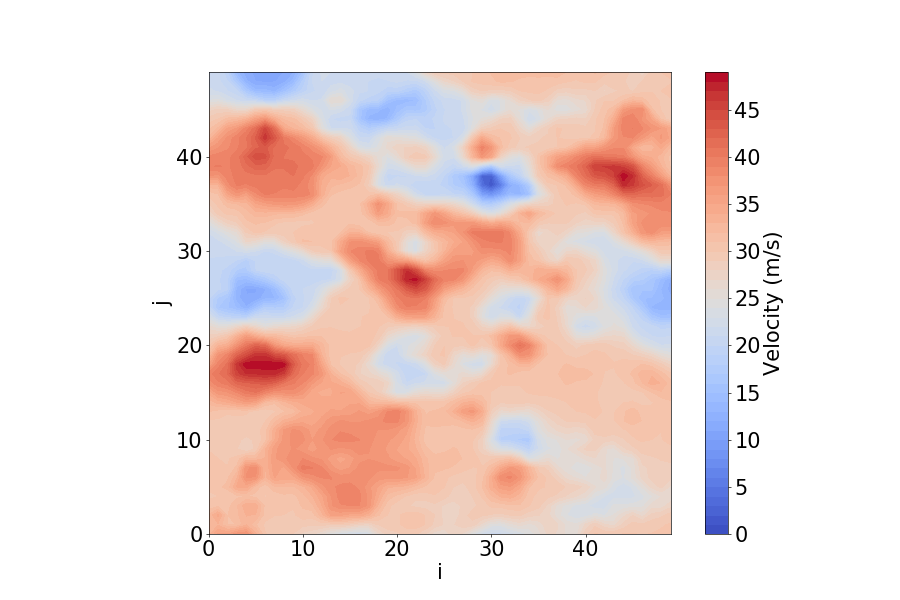

In [12]:
base_url = 'http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/'
catalog_file = requests.get(base_url + 'catalog.xml')
tree = etree.fromstring(catalog_file.content)
folders = []
for children in tree[2]:
    if not '.' in children.get('name'):
        folders.append(children.get('name'))

widget.interactive(g, 
                   folder=widget.Select(options=folders,
                                        value='cc',
                                        description='Folder : '
                                        ),
                   variable=widget.Select(options=['u', 'v', 'norm'],
                                          description='Select a variable to plot'
                                        ),
                   vector=widget.Checkbox(value=False,
                                          description='Display vectors'
                                         ),
                   launch=widget.ToggleButton(value=False,
                                              description= 'Load files'
                                             )
                   )

## Display animation :

In [13]:
HTML(ani.to_jshtml())

Loading frame 1/20
Loading frame 1/20
Loading frame 2/20
Loading frame 3/20
Loading frame 4/20
Loading frame 5/20
Loading frame 6/20
Loading frame 7/20
Loading frame 8/20
Loading frame 9/20
Loading frame 10/20
Loading frame 11/20
Loading frame 12/20
Loading frame 13/20
Loading frame 14/20
Loading frame 15/20
Loading frame 16/20
Loading frame 17/20
Loading frame 18/20
Loading frame 19/20
Loading frame 20/20


Loading frame 19/20
